In [2]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 61.9 MB/s eta 0:00:00


In [3]:
# Import necessary packages
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import EarlyStopping

In [4]:
import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls "/content/drive/My Drive/Colab Notebooks"

 all_train.csv.gz		   'Copy of ML Project 1.ipynb'   Untitled0.ipynb
'Case Study 6_Anish_Tuning.ipynb'  'HW6 sample1.ipynb'
'Case Study 6_NNmodel'		   'HW6 sample.ipynb'


In [5]:
data = pd.read_csv("/content/drive/My Drive/all_train.csv.gz", compression='gzip')

In [6]:
X = data.iloc[:, 1:]  # Features: f0 to f26 + 'mass'
y = data.iloc[:, 0]   # Target variable

# Split data for training and validation
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=100)

# Scale the data
scaler = StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

In [7]:
# Define the PyTorch Dataset class
class HWDataset(Dataset):
    def __init__(self, X_dataFrame, y_dataFrame):
        self.X = X_dataFrame
        self.y = y_dataFrame

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        inputs = torch.tensor(self.X.iloc[idx, :]).float()
        targets = torch.tensor(self.y.iloc[idx]).float()
        return inputs, targets

In [8]:
# Create DataLoaders for the tuning phase
train_data = HWDataset(x_train, y_train)
valid_data = HWDataset(x_test, y_test)
train_dataloader = DataLoader(train_data, batch_size=1000, shuffle=True, num_workers=10)
test_dataloader = DataLoader(valid_data, batch_size=1000, shuffle=False, num_workers=10)

In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
class BigModel(LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(28, 1000),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1000, 1),
            nn.Sigmoid()  # Use Sigmoid if you're using BCELoss
        )
        self.loss = nn.BCELoss()  # Use BCEWithLogitsLoss if you remove the Sigmoid()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat.squeeze(), y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat.squeeze(), y)
        self.log("val_loss", loss)
        acc = accuracy_score(y.detach().cpu(), (y_hat.detach().cpu().squeeze() > 0.5).int())
        self.log("val_acc", acc)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-4)

In [11]:
csv_logger = CSVLogger(save_dir='logs', name='tuning_logs')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')

In [12]:
trainer = Trainer(
    max_epochs=5,
    logger=csv_logger,
    callbacks=[early_stopping],
    devices=1 if torch.cuda.is_available() else 1,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu'
)

model = BigModel()
trainer.fit(model, train_dataloader, test_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 1.0 M  | train
1 | loss  | BCELoss    | 0      | train
---------------------------------------------
1.0 M  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

<ipython-input-7-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-7-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-7-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-7-3b88db18e08e>:11: Futur

Training: |          | 0/? [00:00<?, ?it/s]

<ipython-input-7-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-7-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-7-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-7-3b88db18e08e>:11: Futur

Validation: |          | 0/? [00:00<?, ?it/s]

<ipython-input-7-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-7-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-7-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-7-3b88db18e08e>:11: Futur

Validation: |          | 0/? [00:00<?, ?it/s]

<ipython-input-7-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-7-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-7-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-7-3b88db18e08e>:11: Futur

Validation: |          | 0/? [00:00<?, ?it/s]

<ipython-input-7-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-7-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-7-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-7-3b88db18e08e>:11: Futur

Validation: |          | 0/? [00:00<?, ?it/s]

<ipython-input-7-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-7-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-7-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-7-3b88db18e08e>:11: Futur

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


<ipython-input-7-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-7-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-7-3b88db18e08e>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inputs = torch.tensor(self.X.iloc[idx, :]).float()
<ipython-input-7-3b88db18e08e>:11: Futur

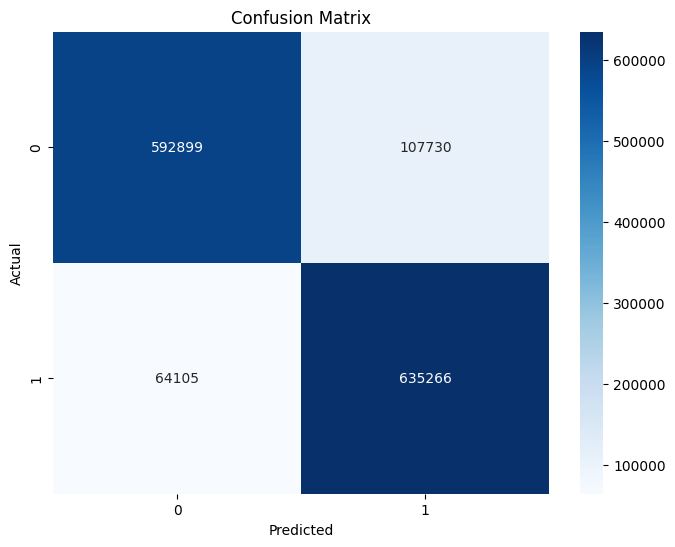

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions on the test set
predictions = []
targets = []

model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        x, y = batch
        y_hat = model(x)
        predictions.extend((y_hat.squeeze() > 0.5).int().tolist())
        targets.extend(y.tolist())

# Plot confusion matrix
cm = confusion_matrix(targets, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

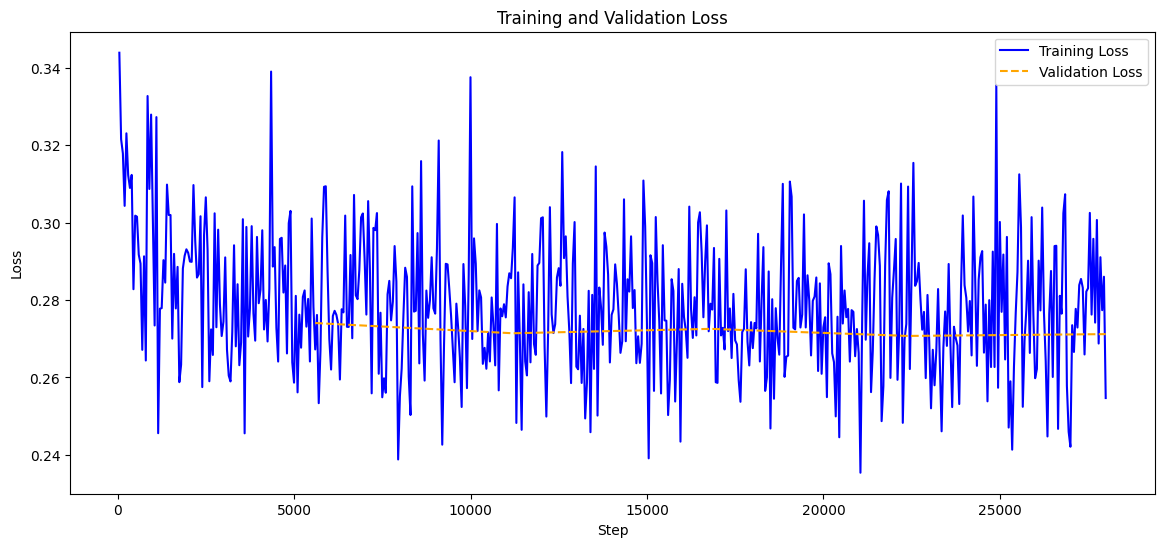

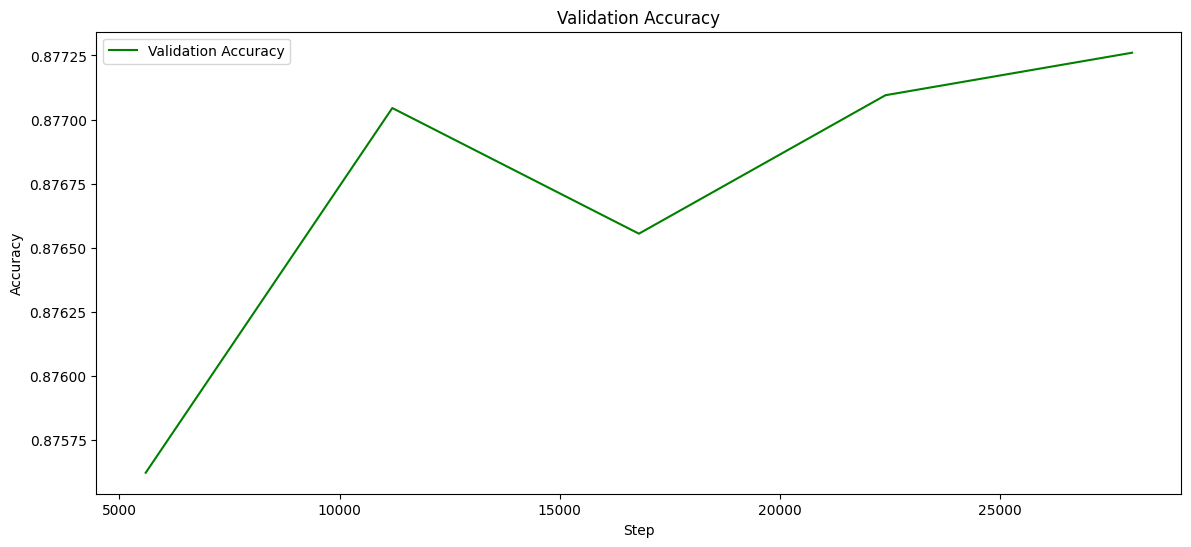

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the metrics CSV file
metrics = pd.read_csv('logs/tuning_logs/version_0/metrics.csv')

# Plot training and validation loss
plt.figure(figsize=(14, 6))
plt.plot(metrics['step'][metrics['train_loss'].notna()], metrics['train_loss'].dropna(), label='Training Loss', color='blue')
plt.plot(metrics['step'][metrics['val_loss'].notna()], metrics['val_loss'].dropna(), label='Validation Loss', color='orange', linestyle='--')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot validation accuracy
plt.figure(figsize=(14, 6))
plt.plot(metrics['step'][metrics['val_acc'].notna()], metrics['val_acc'].dropna(), label='Validation Accuracy', color='green')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()